In [1]:
# Read the dataset
import scipy.io as spio
import numpy as np

BahramFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/BahramFace.mat')
DJFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/DJFace.mat')
NickFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/NickFace.mat')
RoohiFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/RoohiFace.mat')
SarahFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/SarahFace.mat')

AllData = np.concatenate((BahramFace['Intensification_Data'],
                            DJFace['Intensification_Data'],
                            NickFace['Intensification_Data'],
                            RoohiFace['Intensification_Data'],
                            SarahFace['Intensification_Data']), axis=0)

AllLabels = np.concatenate((BahramFace['Intensification_Label'],
                            DJFace['Intensification_Label'],
                            NickFace['Intensification_Label'],
                            RoohiFace['Intensification_Label'],
                            SarahFace['Intensification_Label']), axis=0)

print(AllData.shape, AllData.dtype, AllLabels.shape, AllLabels.dtype)
print(np.mean(AllLabels==0), np.mean(AllLabels==1), np.mean(AllLabels==2), np.mean(AllLabels==3))
print((AllLabels +  1).max(axis=0))

(18720, 205, 16) float64 (18720, 1) uint8
0.833333333333 0.166666666667 0.0 0.0
[2]


In [2]:
# Train and test split
from sklearn.model_selection import train_test_split

X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(AllData, AllLabels, test_size=0.30)

print(X_train_valid.shape, X_test.shape, Y_train_valid.shape, Y_test.shape)

(13104, 205, 16) (5616, 205, 16) (13104, 1) (5616, 1)


In [3]:
from utilities import *

# Normalizing/standardizing the input data features
X_train_valid_norm, X_test_norm = standardize(test=X_test, train=X_train_valid)

# Onehot encoding/vectorizing the output data labels
print(np.mean((Y_train_valid+1).reshape(-1)==0), np.mean((Y_train_valid+1).reshape(-1)==1),
     np.mean((Y_train_valid+1).reshape(-1)==2), np.mean((Y_train_valid+1).reshape(-1)==3))

print(np.mean((Y_test+1).reshape(-1)==0), np.mean((Y_test+1).reshape(-1)==1),
     np.mean((Y_test+1).reshape(-1)==2), np.mean((Y_test+1).reshape(-1)==3))

# Y_train_valid_onehot = one_hot(labels=(Y_train_valid+1).reshape(-1), n_class=2) 
# print(Y_train_valid_onehot.shape, Y_train_valid_onehot.dtype, 
Y_test_onehot = one_hot(labels=(Y_test+1).reshape(-1), n_class=2) 
print(Y_test_onehot.shape, Y_test_onehot.dtype)

0.0 0.834630647131 0.165369352869 0.0
0.0 0.830306267806 0.169693732194 0.0
(5616, 2) float64


In [4]:
# 70% train 30 % valid
# get_batches from each train and valid the same
# still it will be 70% to 30%
# get_batches 83% vs 16%
# get_batch 16% vs 16% each time
# X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(AllData, AllLabels, test_size=0.30)
X_train_norm, X_valid_norm, Y_train, Y_valid = train_test_split(X_train_valid_norm, Y_train_valid, 
                                                                              test_size=0.30)

In [17]:
def get_batches2(X_norm, Y_labels):
    # Input train or valid
    # This is not-applicable to test
    X, Y = X_norm, Y_labels #_onehot
    AllLabels = Y_labels # 100%

    # non = 0 is 87%  AllLabelZero
    # tgt = 1 is 13%  AllLabelOne
    AllLabelZero = (AllLabels==0).reshape(-1) # 87%
    AllLabelOne = (AllLabels==1).reshape(-1) # 13%

    X_non, Y_non = X[AllLabelZero], Y[AllLabelZero] # 87%
    X_tgt, Y_tgt = X[AllLabelOne], Y[AllLabelOne] # 13%
    #     print('X_non.shape, Y_non.shape', X_non.shape, Y_non.shape)
    #     print('X_tgt.shape, Y_tgt.shape', X_tgt.shape, Y_tgt.shape)

    # Non-target batch size for get_batches from non-target data
    batch_size = X_tgt.shape[0] # 13% -> tgt = 1 is 13%  AllLabelOne
    assert X_tgt.shape[0] == Y_tgt.shape[0]
    #     print(batch_size)

    # # 87% - 13% +1: non - tgt + 1
    # n_batches = X_non.shape[0] - tgt_batch_size + 1 # stride=1 
    # # max overlap for non-tgt 87% - 13% +1

    #     # 87% // 13%: non/ tgt
    #     # max overlap for non-tgt 87%// 13%
    #     num_non_batches = X_non.shape[0]// tgt_batch_size # stride= tgt_batch_size 
    # #     print(num_non_batches)
    #     # # n_batches = len(X) // batch_size # stride=batch_size # min overlap
    #     X_non_, Y_non_ = X_non[:num_non_batches*tgt_batch_size], Y_non[:num_non_batches*tgt_batch_size]

    n_batches = X_non.shape[0] // batch_size
    X_non, Y_non = X_non[:n_batches*batch_size], Y_non[:n_batches*batch_size]
    
    #     """ Return a generator for batches """
    #     n_batches = len(X) // batch_size
    #     X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over target batches: start, stop, step
    for i in range(0, X_non.shape[0], batch_size):
        #         print(i)
        # each_train_valid_batch
        each_X_norm = np.concatenate((X_non[i:i+batch_size], X_tgt), axis=0)
        each_Y = np.concatenate((Y_non[i:i+batch_size], Y_tgt), axis=0)
        each_Y_onehot = one_hot(labels=(each_Y+1).reshape(-1), n_class=2)
#         np.random.shuffle(each_X_norm)
#         np.random.shuffle(each_Y_onehot)
        #         print('each_X_norm.shape, each_Y_onehot.shape', each_X_norm.shape, each_Y_onehot.shape)
        #         print('each_X_norm.dtype, each_Y_onehot.dtype', each_X_norm.dtype, each_Y_onehot.dtype)
        yield each_X_norm, each_Y_onehot

In [18]:
get_batches2(X_norm=X_valid_norm, Y_labels=Y_valid)

<generator object get_batches2 at 0x7f05e8610e08>

In [19]:
get_batches2(X_norm=X_train_norm, Y_labels=Y_train)

<generator object get_batches2 at 0x7f05e8795db0>

In [20]:
## Hyperparameters
# Input data
# batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
# print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)
print('seq_len, n_channels', seq_len, n_channels)

# Output labels
n_classes = Y_train_valid.max(axis=0)+1
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)
print('n_classes', n_classes)

# learning parameters
learning_rate = 0.0001 #1e-4
epochs = 200 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

seq_len, n_channels 205 16
n_classes [2]


In [21]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [22]:
# Feed the data from python/numpy to tensorflow framework
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')
print('inputs_.shape, labels_.shape', inputs_.shape, labels_.shape)

inputs_.shape, labels_.shape (?, 205, 16) (?, 2)


In [23]:
# inputs_.shape, labels_.shape (?, 205, 16) (?, 2)
# (batch, 205, 16) --> (batch, 102, 32)
# conv valid: (205-2+0)/1 + 1 = (203/1)+1 = 203 + 1=204
# pool same: (204-2+0)/2 + 1 = (202/2)+1 = 101 + 1=102
conv1 = tf.layers.conv1d(inputs=inputs_, filters=32, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
# max_pool_1 = tf.nn.dropout(max_pool_1, keep_prob=keep_prob_)
print('inputs_.shape, conv1.shape, max_pool_1.shape', inputs_.shape, conv1.shape, max_pool_1.shape)

# (batch, 102, 32) --> (batch, 51, 64)
# conv same
# pool same: (102-2+0)/2 + 1 = (100/2)+1 = 50 + 1=51
conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=64, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
# max_pool_2 = tf.nn.dropout(max_pool_2, keep_prob=keep_prob_)
print('max_pool_1.shape, conv2.shape, max_pool_2.shape', max_pool_1.shape, conv2.shape, max_pool_2.shape)

# (batch, 51, 64) --> (batch, 25, 128)
# conv valid: (51-2+0)/1 + 1 = (49/1)+1 = 49 + 1=50
# pool same: (50-2+0)/2 + 1 = (48/2)+1 = 24 + 1=25
conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=128, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
# max_pool_3 = tf.nn.dropout(max_pool_3, keep_prob=keep_prob_)
print('max_pool_2.shape, conv3.shape, max_pool_3.shape', max_pool_2.shape, conv3.shape, max_pool_3.shape)

# (batch, 25, 128) --> (batch, 12, 256)
# conv valid: (25-2+0)/1 + 1 = (23/1)+1 = 23 + 1=24
# pool same: (24-2+0)/2 + 1 = (22/2)+1 = 11 + 1=12
conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=256, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
# max_pool_4 = tf.nn.dropout(max_pool_4, keep_prob=keep_prob_)
print('max_pool_3.shape, conv4.shape, max_pool_4.shape', max_pool_3.shape, conv4.shape, max_pool_4.shape)

# Flatten and add dropout + predicted output
flat = tf.reshape(max_pool_4, (-1, 12*256))
flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
logits = tf.layers.dense(flat, n_classes)
print('max_pool_4.shape, flat.shape, logits.shape', max_pool_4.shape, flat.shape, logits.shape)

inputs_.shape, conv1.shape, max_pool_1.shape (?, 205, 16) (?, 204, 32) (?, 102, 32)
max_pool_1.shape, conv2.shape, max_pool_2.shape (?, 102, 32) (?, 102, 64) (?, 51, 64)
max_pool_2.shape, conv3.shape, max_pool_3.shape (?, 51, 64) (?, 50, 128) (?, 25, 128)
max_pool_3.shape, conv4.shape, max_pool_4.shape (?, 25, 128) (?, 24, 256) (?, 12, 256)
max_pool_4.shape, flat.shape, logits.shape (?, 12, 256) (?, 3072) (?, 2)


In [24]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)
print('cost_tensor, cost', cost_tensor, cost)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)
print('optimizer', optimizer)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
print('correct_pred, accuracy', correct_pred, accuracy)

# Confusion matrix
confusion_matrix = tf.confusion_matrix(predictions=tf.argmax(logits, 1),
                                       labels=tf.argmax(labels_, 1))
print('confusion_matrix', confusion_matrix)

cost_tensor, cost Tensor("Reshape_7:0", shape=(?,), dtype=float32) Tensor("Mean_1:0", shape=(), dtype=float32)
optimizer name: "Adam_1"
op: "NoOp"
input: "^Adam_1/update_conv1d_4/kernel/ApplyAdam"
input: "^Adam_1/update_conv1d_4/bias/ApplyAdam"
input: "^Adam_1/update_conv1d_5/kernel/ApplyAdam"
input: "^Adam_1/update_conv1d_5/bias/ApplyAdam"
input: "^Adam_1/update_conv1d_6/kernel/ApplyAdam"
input: "^Adam_1/update_conv1d_6/bias/ApplyAdam"
input: "^Adam_1/update_conv1d_7/kernel/ApplyAdam"
input: "^Adam_1/update_conv1d_7/bias/ApplyAdam"
input: "^Adam_1/update_dense_1/kernel/ApplyAdam"
input: "^Adam_1/update_dense_1/bias/ApplyAdam"
input: "^Adam_1/Assign"
input: "^Adam_1/Assign_1"

correct_pred, accuracy Tensor("Equal_1:0", shape=(?,), dtype=bool) Tensor("accuracy_1:0", shape=(), dtype=float32)
confusion_matrix Tensor("confusion_matrix_1/SparseTensorDenseAdd:0", shape=(?, ?), dtype=int32)


In [25]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        #         for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
        for x, y in get_batches2(X_norm=X_train_norm, Y_labels=Y_train):
            
            ######################## Training
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : keep_prob, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################## Validation
            acc_batch = []
            loss_batch = []    
            # Loop over batches
            #             for x, y in get_batches(X_valid_norm, Y_valid_onehot, batch_size):
            for x, y in get_batches2(X_norm=X_valid_norm, Y_labels=Y_valid):

                # Feed dictionary
                feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

                # Loss
                loss, acc = sess.run([cost, accuracy], feed_dict = feed)
                acc_batch.append(acc)
                loss_batch.append(loss)

            # Store
            valid_acc.append(np.mean(acc_batch))
            valid_loss.append(np.mean(loss_batch))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(np.mean(train_loss)),
              "Valid loss: {:.6f}".format(np.mean(valid_loss)),
              "Train acc: {:6f}".format(np.mean(train_acc)),
              "Valid acc: {:.6f}".format(np.mean(valid_acc)))
                
    saver.save(sess,"checkpoints/dcnn-face-yalda-Copy2.ckpt")

Epoch: 1/200 Train loss: 0.695843 Valid loss: 0.689248 Train acc: 0.520430 Valid acc: 0.551657
Epoch: 2/200 Train loss: 0.691074 Valid loss: 0.685239 Train acc: 0.539146 Valid acc: 0.581425
Epoch: 3/200 Train loss: 0.686019 Valid loss: 0.681397 Train acc: 0.554435 Valid acc: 0.599423
Epoch: 4/200 Train loss: 0.680858 Valid loss: 0.677510 Train acc: 0.569926 Valid acc: 0.612233
Epoch: 5/200 Train loss: 0.675701 Valid loss: 0.673574 Train acc: 0.585134 Valid acc: 0.623078
Epoch: 6/200 Train loss: 0.670502 Valid loss: 0.669469 Train acc: 0.597614 Valid acc: 0.632259
Epoch: 7/200 Train loss: 0.664962 Valid loss: 0.665153 Train acc: 0.609649 Valid acc: 0.639596
Epoch: 8/200 Train loss: 0.659545 Valid loss: 0.660641 Train acc: 0.620296 Valid acc: 0.646603
Epoch: 9/200 Train loss: 0.653934 Valid loss: 0.655896 Train acc: 0.629898 Valid acc: 0.653199
Epoch: 10/200 Train loss: 0.647762 Valid loss: 0.650938 Train acc: 0.638327 Valid acc: 0.659168
Epoch: 11/200 Train loss: 0.641434 Valid loss: 0.

Epoch: 87/200 Train loss: 0.419237 Valid loss: 0.490235 Train acc: 0.806024 Valid acc: 0.773902
Epoch: 88/200 Train loss: 0.417951 Valid loss: 0.489796 Train acc: 0.806769 Valid acc: 0.774300
Epoch: 89/200 Train loss: 0.416699 Valid loss: 0.489366 Train acc: 0.807498 Valid acc: 0.774694
Epoch: 90/200 Train loss: 0.415463 Valid loss: 0.488947 Train acc: 0.808227 Valid acc: 0.775079
Epoch: 91/200 Train loss: 0.414238 Valid loss: 0.488536 Train acc: 0.808942 Valid acc: 0.775448
Epoch: 92/200 Train loss: 0.412993 Valid loss: 0.488147 Train acc: 0.809682 Valid acc: 0.775805
Epoch: 93/200 Train loss: 0.411797 Valid loss: 0.487763 Train acc: 0.810396 Valid acc: 0.776166
Epoch: 94/200 Train loss: 0.410588 Valid loss: 0.487396 Train acc: 0.811086 Valid acc: 0.776502
Epoch: 95/200 Train loss: 0.409412 Valid loss: 0.487033 Train acc: 0.811754 Valid acc: 0.776818
Epoch: 96/200 Train loss: 0.408205 Valid loss: 0.486690 Train acc: 0.812464 Valid acc: 0.777129
Epoch: 97/200 Train loss: 0.407005 Valid

Epoch: 172/200 Train loss: 0.332562 Valid loss: 0.485398 Train acc: 0.854809 Valid acc: 0.788445
Epoch: 173/200 Train loss: 0.331700 Valid loss: 0.485656 Train acc: 0.855257 Valid acc: 0.788475
Epoch: 174/200 Train loss: 0.330839 Valid loss: 0.485912 Train acc: 0.855717 Valid acc: 0.788511
Epoch: 175/200 Train loss: 0.329981 Valid loss: 0.486152 Train acc: 0.856163 Valid acc: 0.788545
Epoch: 176/200 Train loss: 0.329134 Valid loss: 0.486435 Train acc: 0.856618 Valid acc: 0.788577
Epoch: 177/200 Train loss: 0.328287 Valid loss: 0.486720 Train acc: 0.857062 Valid acc: 0.788612
Epoch: 178/200 Train loss: 0.327435 Valid loss: 0.486978 Train acc: 0.857517 Valid acc: 0.788651
Epoch: 179/200 Train loss: 0.326596 Valid loss: 0.487251 Train acc: 0.857953 Valid acc: 0.788685
Epoch: 180/200 Train loss: 0.325762 Valid loss: 0.487534 Train acc: 0.858396 Valid acc: 0.788715
Epoch: 181/200 Train loss: 0.324928 Valid loss: 0.487804 Train acc: 0.858840 Valid acc: 0.788743
Epoch: 182/200 Train loss: 0.3

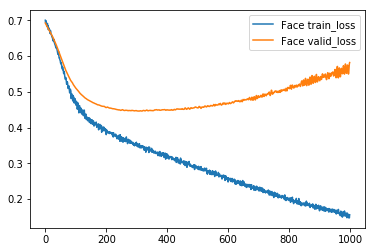

In [26]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='Face train_loss')
mplot.plot(valid_loss, label='Face valid_loss')
mplot.legend()
mplot.show()

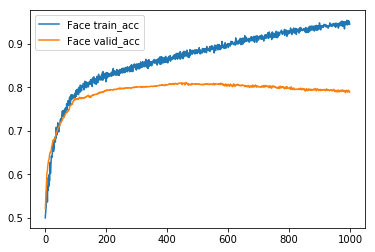

In [27]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc, label='Face train_acc')
mplot.plot(valid_acc, label='Face valid_acc')
mplot.legend()
mplot.show()

In [28]:
test_acc, test_loss = [], []

with tf.Session() as sess:
    # Restore the validated model
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
    
    ################## Test
    acc_batch = []
    loss_batch = []    
    # Loop over batches
    for x, y in get_batches(batch_size=100, X=X_test_norm, y=Y_test_onehot):

        # Feed dictionary
        feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

        # Loss
        loss, acc = sess.run([cost, accuracy], feed_dict = feed)
        acc_batch.append(acc)
        loss_batch.append(loss)

    # Store
    test_acc.append(np.mean(acc_batch))
    test_loss.append(np.mean(loss_batch))

    # Print info for every iter/epoch
    print("Test loss: {:6f}".format(np.mean(test_loss)),
          "Test acc: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints/dcnn-face-yalda-Copy2.ckpt
Test loss: 0.338009 Test acc: 0.876786
